                  İSTANBUL SAĞLIK VE TEKNOLOJİ ÜNİVERSİTESİ
                        YAZILIM MÜHENDİSLİĞİ
                  YAPAY ZEKAYA GİRİŞ DERSİ DÖNEMİÇİ PROJESİ
                    
                    FARE HAREKETLERİNDEN STRES VE HORMONAL
                        DEĞİŞİMLERİNİ EĞİTTİMİZ MODELİMİZ

                              
                               HAZIRLAYANLAR:
                          SELAMİ ÇETİN 220609012
                        UĞUR BAKİ ARSLAN 220609015
                        YUNUS EMRE SEVİNÇ 220609007


Bu kodumuzda annotations.xml dosyasını işleyerek içerisindeki iskelet noktalarının koordinatlarını her bir zaman dilimi (frame) için okuyup bir pandas DataFrame'ine dönüştürdük.

In [22]:
import xml.etree.ElementTree as ET
import pandas as pd

# XML dosyasını parse etme
tree = ET.parse('annotations.xml')
root = tree.getroot()
from lxml import etree

parser = etree.XMLParser(recover=True)  # Hataları görmezden gel
tree = etree.parse("annotations.xml", parser=parser)
# Veriyi depolamak için liste
data = []

# Her frame için koordinatları çekme
for frame in root.findall('frame'):
    zaman = float(frame.get('zaman'))
    noktalar = {f"x{i}": None for i in range(1, 17)} | {f"y{i}": None for i in range(1, 17)}

    for nokta in frame.findall('nokta'):
        nokta_id = int(nokta.get('id'))
        noktalar[f"x{nokta_id}"] = float(nokta.get('x'))
        noktalar[f"y{nokta_id}"] = float(nokta.get('y'))

    data.append({"zaman": zaman, **noktalar})

# DataFrame'e dönüştürme
df = pd.DataFrame(data)

In [ ]:
import numpy as np  # NumPy kütüphanesini "np" takma adıyla import et
# 1. Merkez nokta (tüm noktaların ortalaması)
df['x_merkez'] = df.filter(like='x').mean(axis=1)
df['y_merkez'] = df.filter(like='y').mean(axis=1)

# 2. Hız hesaplama (bir önceki frame ile)
df['hiz'] = np.sqrt(df['x_merkez'].diff()**2 + df['y_merkez'].diff()**2)

# 3. Donma davranışı (hiz < eşik değer)
df['donma'] = (df['hiz'] < 5).astype(int)

Bu kodumuzda, iskelet noktalarının koordinatları üzerinden hareket analizi yaparak, farenin hareket hızı ve donma (freeze) davranışı gibi davranışsal ipuçlarını çıkarmaya yönelik bir adımdır.

🔍 Genel Mantığı:
Kodun amacı, her bir karede (frame'de) farenin ne kadar hareket ettiğini ölçmek ve bu hareketin çok az olduğu, yani neredeyse sabit kaldığı (donduğu) anları tespit etmektir. Bunu şu şekilde yapıyor:

Tüm vücut noktalarının ortalamasını alarak bir merkez pozisyon belirleniyor. Yani "farenin gövdesi genel olarak nerede?" sorusuna cevap veriliyor.

Ardından, bu merkez pozisyonlar arasındaki fark kullanılarak hareket hızı hesaplanıyor. İki kare arasındaki pozisyon değişimi ne kadar büyükse, hız o kadar yüksek.

Son olarak, eğer bu hız belli bir eşikten küçükse (örneğin 5 piksel/frame gibi), bu durum donma (freeze) olarak etiketleniyor. Böylece fare uzun süre hareket etmediyse bu durum davranışsal bir sinyal olarak işaretlenmiş oluyor.

📌 Neden önemli?
Bu tür bilgiler, özellikle stres, korku veya anksiyete gibi durumların tahmininde çok kritiktir çünkü donma, hayvan davranışında yaygın bir stres tepkisidir.

In [ ]:
# 1. Köşelerde geçirilen süre (örneğin sol üst köşe: x<50, y<50)
df['kose_sol_ust'] = ((df['x_merkez'] < 50) & (df['y_merkez'] < 50)).astype(int)

# 2. Alan kullanımı (kutuyu 4 bölgeye ayırma)
df['bolge'] = pd.cut(df['x_merkez'], bins=[0, 100, 200, 300, 400], labels=[1, 2, 3, 4])

Bu kodumuzda, farenin konum verisini kullanarak mekânsal davranış analizi yapar. Amaç, hayvanın test alanı içinde nerede ne kadar zaman geçirdiğini ve hangi bölgeleri daha çok tercih ettiğini ölçmektir.

🧠 Genel Mantığı:
Köşelerde geçirilen süre:

Farenin sol üst köşede olup olmadığını kontrol eder (x < 50 ve y < 50).

Eğer bu koşul sağlanıyorsa, o karede hayvanın sol üst köşede olduğu kabul edilir ve 1 ile işaretlenir, aksi halde 0.

Bu bilgi, farenin genellikle güvenli bölgelerde (duvar/köşe) saklanma davranışı gösterip göstermediğini anlamak için kullanılır. Stresli hayvanlar genellikle köşelere çekilir.

Alan kullanımı:

Ortamın yatay düzlemde (x eksenine göre) 4 eşit bölgeye ayrılması sağlanır.

pd.cut fonksiyonu ile x_merkez değerine göre her kare bir bölgeye atanır (1. bölge: en sol, 4. bölge: en sağ).

Böylece fare hangi bölgelerde daha fazla zaman geçirmiş kolayca analiz edilebilir.

🧭 Neden önemli?
Farenin hareket ettiği alanlar davranışsal anlam taşır:

Alanın sadece belirli bölgelerinde vakit geçiren bir fare, kaygılı ya da merak duygusu düşük olabilir.

Tüm alanı aktif kullanan bir fare, daha rahat veya keşfetmeye açık olabilir.

Bu tarz mekânsal özellikler, stres/anksiyete tahminine katkı sağlayan güçlü davranışsal göstergelerdir.

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split

# Set random seed for reproducibility
np.random.seed(42)

# Create synthetic data for 500 mice
n_samples = 500

# Movement features
data = {
    'hareket_hizi': np.random.normal(10, 3, n_samples).clip(5, 20),
    'donma_suresi': np.random.normal(15, 8, n_samples).clip(0, 40),
    'maruz_kalma_suresi': np.random.normal(20, 10, n_samples).clip(5, 50),
    'yemek_yeme_suresi': np.random.normal(100, 30, n_samples).clip(30, 180),
    'sosyal_etkilesim': np.random.normal(50, 20, n_samples).clip(5, 120),
    'kortikosteron': np.random.normal(50, 20, n_samples).clip(20, 100),
    'kalp_atis': np.random.normal(400, 100, n_samples).clip(300, 600),
}

# Create DataFrame
df = pd.DataFrame(data)

# Generate stress levels based on features
conditions = [
    (df['donma_suresi'] < 10) & (df['kortikosteron'] < 40),
    (df['donma_suresi'] >= 20) | (df['kortikosteron'] >= 70),
]
choices = [0, 2]  # 0=Low stress, 2=High stress
df['stres_seviyesi'] = np.select(conditions, choices, default=1)  # 1=Medium stress

# Verify distribution
print("Stress Level Distribution:")
print(df['stres_seviyesi'].value_counts())

# Save to CSV
df.to_csv('Fare.csv', index=False)
print("Dataset saved to 'mouse_stress_data.csv'")

# Prepare for ML
X = df.drop('stres_seviyesi', axis=1)
y = df['stres_seviyesi']

# Split data only if we have samples
if len(X) > 0:
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    print(f"\nTrain shape: {X_train.shape}, Test shape: {X_test.shape}")
else:
    print("Error: No samples available for training!")

Stress Level Distribution:
stres_seviyesi
1    277
2    184
0     39
Name: count, dtype: int64
Dataset saved to 'mouse_stress_data.csv'

Train shape: (400, 7), Test shape: (100, 7)


Bu kodumuzda, fare davranış ve fizyolojik verilerini kullanarak stres seviyesi sınıflandırması için yapay bir veri seti üretir ve bu veriyi makine öğrenmesi modeline uygun şekilde hazırlar.

🧠 Genel Mantığı:
🔧 1. Sentetik Veri Üretimi (Simülasyon)
Gerçek deney verisi yerine, istatistiksel olarak benzer (ama rastgele oluşturulmuş) 500 adet fare gözlemi oluşturuluyor.

Her bir fare için farklı özellikler tanımlanmış:

hareket_hizi, donma_suresi, maruz_kalma_suresi gibi davranışsal;

kortikosteron (stres hormonu) ve kalp_atis gibi fizyolojik veriler.

Bu veriler, normal dağılım (Gaussian) temel alınarak rastgele ama belirli aralıklarla üretiliyor (clip ile sınırlandırılıyor).

🔎 2. Etiket Oluşturma (Stres Seviyesi)
Stres seviyesi, bazı kurallara göre belirleniyor:

Düşük stres (0): Donma süresi kısa ve kortikosteron düşük.

Yüksek stres (2): Donma süresi çok uzun ya da kortikosteron yüksek.

Diğer durumlar orta düzey stres (1) olarak atanıyor.

np.select() ile bu koşullara göre yeni bir stres_seviyesi etiketi ekleniyor.

💾 3. Veri Kaydı ve Modellemeye Hazırlık
Veri Fare.csv adıyla CSV dosyasına kaydediliyor.

X (girdi özellikleri) ve y (etiket/stres seviyesi) olarak ayrılıyor.

Veri eğitim ve test seti olarak bölünüyor (train_test_split), böylece makine öğrenmesi algoritmalarında kullanılabilecek duruma getiriliyor.

🔍 Bu Neden Önemli?
Bu yapı sayesinde:


Farklı stres düzeylerini etkileyen faktörleri keşfedebiliriz.

Stres tahminine yönelik modelimizi güvenli bir şekilde test etmemiz sağlanır.

<ipython-input-18-04776efe6d97>:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df, x='stres_seviyesi', palette='viridis')


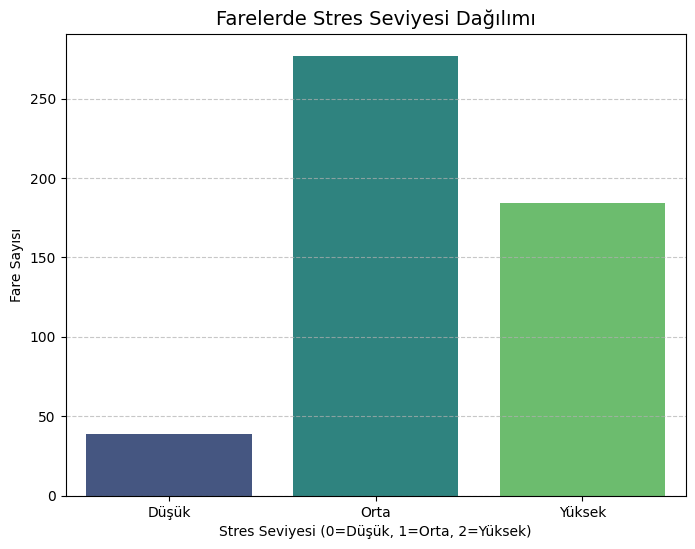

<ipython-input-18-04776efe6d97>:22: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df, x='stres_seviyesi', y='hareket_hizi', palette='coolwarm')


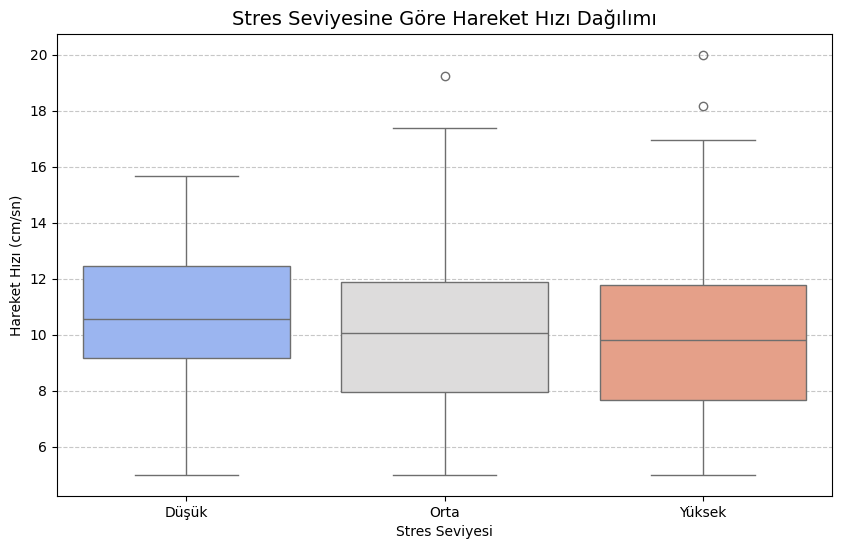

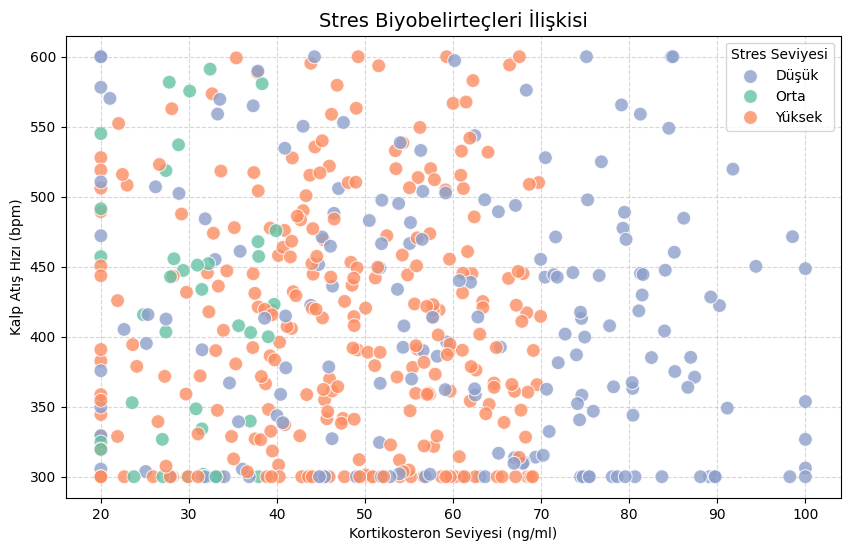

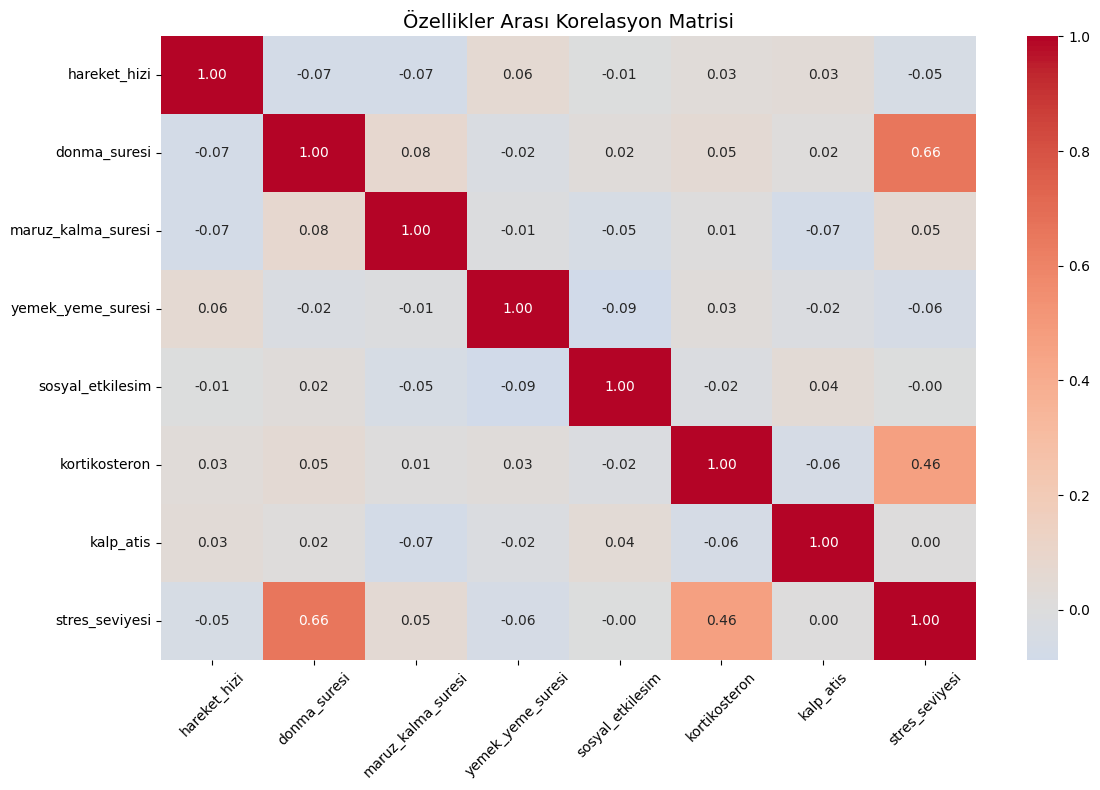

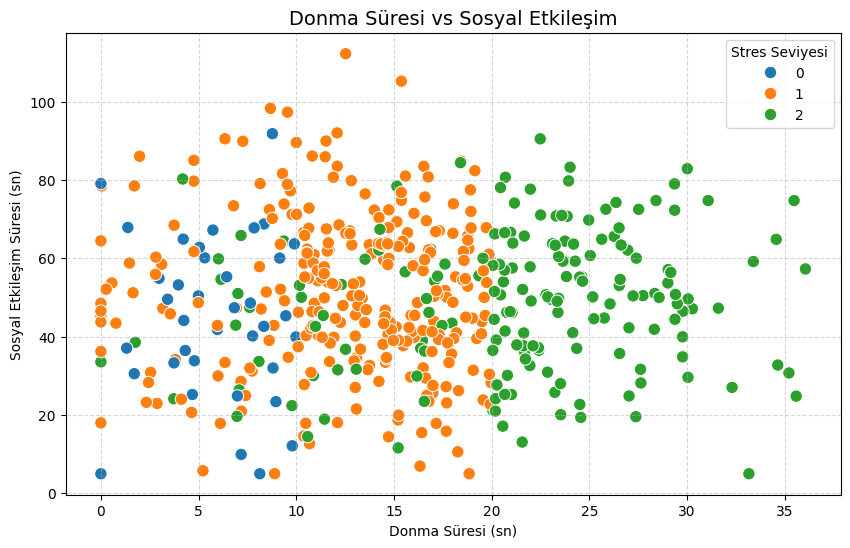

<ipython-input-18-04776efe6d97>:64: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(data=df, x='stres_seviyesi', y='yemek_yeme_suresi', palette='muted')
<ipython-input-18-04776efe6d97>:70: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(data=df, x='stres_seviyesi', y='maruz_kalma_suresi', palette='muted')


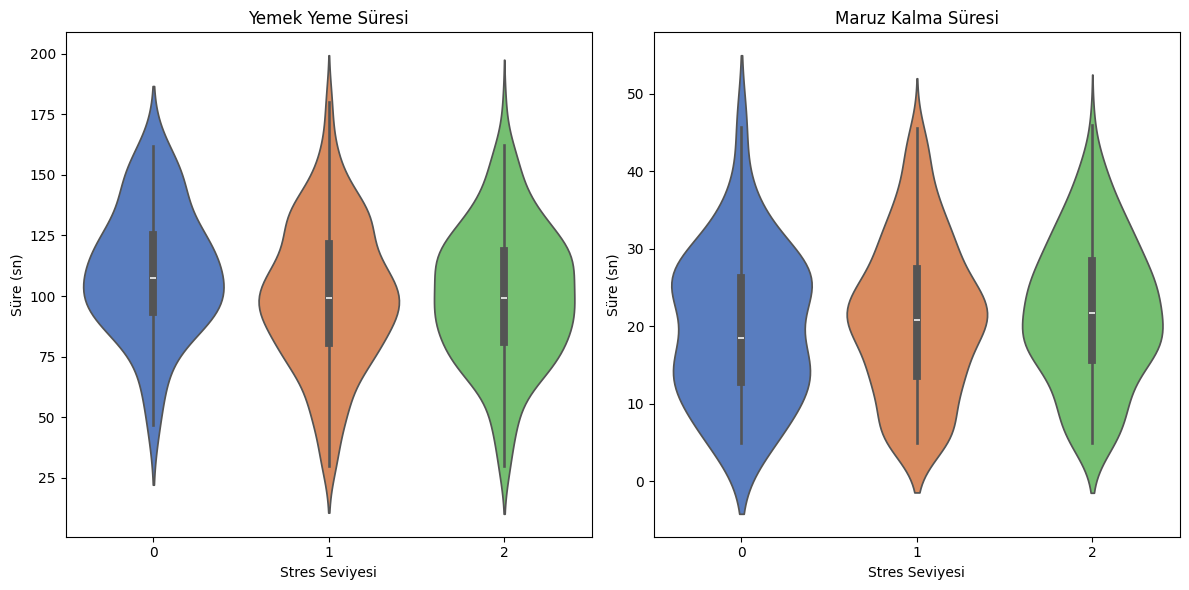

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split

# Veri setini yükle
df = pd.read_csv('Fare.csv')

# 1. Stres Seviyesi Dağılımı
plt.figure(figsize=(8, 6))
sns.countplot(data=df, x='stres_seviyesi', palette='viridis')
plt.title('Farelerde Stres Seviyesi Dağılımı', fontsize=14)
plt.xlabel('Stres Seviyesi (0=Düşük, 1=Orta, 2=Yüksek)')
plt.ylabel('Fare Sayısı')
plt.xticks([0, 1, 2], ['Düşük', 'Orta', 'Yüksek'])
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

# 2. Stres Seviyesine Göre Hareket Hızı
plt.figure(figsize=(10, 6))
sns.boxplot(data=df, x='stres_seviyesi', y='hareket_hizi', palette='coolwarm')
plt.title('Stres Seviyesine Göre Hareket Hızı Dağılımı', fontsize=14)
plt.xlabel('Stres Seviyesi')
plt.ylabel('Hareket Hızı (cm/sn)')
plt.xticks([0, 1, 2], ['Düşük', 'Orta', 'Yüksek'])
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

# 3. Kortikosteron ve Kalp Atışı İlişkisi
plt.figure(figsize=(10, 6))
sns.scatterplot(data=df, x='kortikosteron', y='kalp_atis', hue='stres_seviyesi',
               palette='Set2', s=100, alpha=0.8)
plt.title('Stres Biyobelirteçleri İlişkisi', fontsize=14)
plt.xlabel('Kortikosteron Seviyesi (ng/ml)')
plt.ylabel('Kalp Atış Hızı (bpm)')
plt.legend(title='Stres Seviyesi', labels=['Düşük', 'Orta', 'Yüksek'])
plt.grid(linestyle='--', alpha=0.5)
plt.show()

# 4. Özelliklerin Korelasyon Matrisi
plt.figure(figsize=(12, 8))
corr_matrix = df.corr()
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', center=0, fmt='.2f')
plt.title('Özellikler Arası Korelasyon Matrisi', fontsize=14)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# 5. Donma Süresi ve Sosyal Etkileşim Karşılaştırması
plt.figure(figsize=(10, 6))
sns.scatterplot(data=df, x='donma_suresi', y='sosyal_etkilesim',
               hue='stres_seviyesi', palette='tab10', s=80)
plt.title('Donma Süresi vs Sosyal Etkileşim', fontsize=14)
plt.xlabel('Donma Süresi (sn)')
plt.ylabel('Sosyal Etkileşim Süresi (sn)')
plt.legend(title='Stres Seviyesi')
plt.grid(linestyle='--', alpha=0.5)
plt.show()

# 6. Stres Seviyesine Göre Özelliklerin Dağılımı (Violin Plot)
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
sns.violinplot(data=df, x='stres_seviyesi', y='yemek_yeme_suresi', palette='muted')
plt.title('Yemek Yeme Süresi')
plt.xlabel('Stres Seviyesi')
plt.ylabel('Süre (sn)')

plt.subplot(1, 2, 2)
sns.violinplot(data=df, x='stres_seviyesi', y='maruz_kalma_suresi', palette='muted')
plt.title('Maruz Kalma Süresi')
plt.xlabel('Stres Seviyesi')
plt.ylabel('Süre (sn)')

plt.tight_layout()
plt.show()

🔍 Genel Amaç: Farelerde Stresin Görselleştirilmesi

Bu kodumuzda, elimizdeki veriye sadece sayılar olarak değil, görsel olarak bakmamızı sağlıyor. Böylece, “hangi davranışlar veya biyolojik ölçümler stresle bağlantılı?” sorusuna grafiklerle cevap bulmaya çalışıyoruz.

Bu kodun arkasındaki temel mantık şu:

✅ 1. Verinin Dengesi ve Dağılımını Anlamak
İlk grafik (countplot), hangi stres seviyesinden kaç fare var onu gösteriyor.

Amaç: Veride dengesizlik var mı? Örneğin sadece yüksek stresli fareler fazlaysa, model buna kayabilir.

✅ 2. Davranışların Stresle Nasıl Değiştiğini Görmek
Kutu ve violin grafikler (boxplot, violinplot), belirli bir davranışın (örneğin hareket hızı, yemek süresi) stres seviyesi arttıkça nasıl değiştiğini gösteriyor.

Amaç: "Stres arttıkça fare daha az mı hareket ediyor, daha az mı yiyor?" gibi sorulara yanıt bulmak.

✅ 3. Biyolojik Belirtiler Arasındaki İlişkiyi Gözlemlemek
Kortikosteron ve kalp atış hızı gibi biyobelirteçler için scatter plot kullanılıyor.

Amaç: “Bu iki değer birlikte artıyor mu? Hangi stres grubunda yoğunluk var?” gibi ilişkileri görmek.

✅ 4. Tüm Özellikler Birbirleriyle Nasıl İlişkili?
Isı haritası (korelasyon matrisi), tüm özelliklerin birbiriyle olan bağlantısını gösteriyor.

Amaç: Belki iki farklı değişken aslında aynı bilgiyi taşıyor (yüksek korelasyon). Bu durumda modelde ikisine birden gerek olmayabilir.

✅ 5. Stres Seviyelerine Göre Gruplar Ayırt Edilebiliyor mu?
Grafikler yardımıyla stres seviyesi arttığında gözle görülür değişimler var mı? sorusunu inceliyoruz.

Amaç: Eğer görsel olarak stres seviyeleri ayırt edilebiliyorsa, model de bunu öğrenebilir.

🎯 Özetle:
Bu grafiklerle:

Veriyi tanıyoruz,

Hangi değişkenlerin önemli olabileceğini anlıyoruz,

Modelleme öncesi ön keşif analizi (exploratory data analysis – EDA) yapıyoruz.

Yani bunlar sadece süs değil — veri biliminin ilk adımında yapılması gereken zorunlu bir analizdir.

In [48]:
import xml.etree.ElementTree as ET
import pandas as pd
import numpy as np

# XML'den veri çekme
tree = ET.parse('annotations.xml')
root = tree.getroot()

data = []
for frame in root.findall('frame'):
    frame_id = frame.get('id')
    if frame_id is None:
        continue  # ID yoksa bu frame'i atla
    frame_data = {'frame_id': int(frame_id)}

    for point in frame.findall('point'):
        pid = point.get('id')
        x = point.get('x')
        y = point.get('y')
        if pid is None or x is None or y is None:
            continue
        pid = int(pid)
        frame_data[f'x{pid}'] = float(x)
        frame_data[f'y{pid}'] = float(y)

    data.append(frame_data)

# DataFrame'e dönüştürme
df_xml = pd.DataFrame(data)

# Eğer 'frame_id' index olmuşsa, onu sütun olarak al
if 'frame_id' not in df_xml.columns and df_xml.index.name == 'frame_id':
    df_xml.reset_index(inplace=True)

# Özellik mühendisliği
df_xml['center_x'] = df_xml.filter(like='x').mean(axis=1)
df_xml['center_y'] = df_xml.filter(like='y').mean(axis=1)
df_xml['frame_id']=df_xml.filter(like='frame_id').mean(axis=1)

# Hareket hızı hesaplama (30 FPS)
df_xml['speed'] = np.sqrt(
    df_xml['center_x'].diff()**2 +
    df_xml['center_y'].diff()**2
) /(df_xml['frame_id'].diff() / 30)  # 30 FPS varsayımı

# Donma davranışı
df_xml['freezing'] = (df_xml['speed'] < 5).astype(int)

# Özet özellikler
xml_features = df_xml.groupby('frame_id').agg({
    'speed': ['mean', 'std'],
    'freezing': 'sum'
})
xml_features.columns = ['speed_mean', 'speed_std', 'freezing_count']


# CSV verisini yükle
df_csv = pd.read_csv('Fare.csv')

df_combined = pd.merge(
    left=df_csv,
    right=xml_features,
    left_on='hareket_hizi',
    right_index=True,
    how='inner'
)

# Eksik verileri temizleme
df_combined.dropna(inplace=True)
# Verileri birleştirme (frame_id üzerinden)




🔍 Bu kodun amacı ne?
Bizim elimizde iki farklı verimiz vardı:

Fare davranışları ve biyobelirteçleri (örneğin kortikosteron, kalp atışı vs.) → CSV dosyasından geliyor.

Fare iskelet hareketleri (yani farenin videosundan çıkarılmış iskelet noktaları) → XML dosyasından geliyor.

Bu iki veri, stres gibi içsel durumları daha iyi anlamak için birleştiriliyor.

💡 Peki bu nasıl yapılıyor? Genel Mantık:
1. Fare hareketleri analiz ediliyor.
Fare her karede (frame) farklı pozisyonlarda. Her karenin içinde iskelet noktalarının x ve y koordinatları var.

👉 Bu noktalardan farenin "vücudunun merkezi" hesaplanıyor.

2. Hareket hızı bulunuyor.
İki kare arasındaki pozisyon farkı hesaplanıyor. Bu, farenin ne kadar hızlı hareket ettiğini gösteriyor.

Çünkü stresli hayvanlar ya donup kalır ya da çok hareket eder.

3. Donma davranışı tespit ediliyor.
Eğer hareket hızı çok düşükse (örneğin 5 cm/sn'den azsa), bu kare "donmuş" kabul ediliyor.

Yani fare hiç kıpırdamamış gibi.

Bu davranış sayılıyor. Kaç karede donma olmuş? Bu bilgi tutuluyor.

4. Özet çıkarılıyor.
Tüm kareler için ortalama hız, hızın değişkenliği (kararsızlık) ve toplam donma süresi gibi özet bilgiler üretiliyor.

Bu bilgiler artık tek tek kareler değil, bir bireyin genel stres hareket örüntüsünü yansıtıyor.

5. Bu veriler diğer dosyayla birleştiriliyor.
Fare hakkında başka bilgiler de var: Kortikosteron, kalp atışı, sosyal etkileşim süresi, vb.

Şimdi elimizde hem hareket verisi, hem de biyolojik/davranışsal veri oldu. Bunları birleştiriyoruz.

Böylece elimizde şu tür bir veri seti oluşuyor:


fare	kortikosteron	kalp_atis	hareket_hizi	donma_suresi	...
Bu birleşik veriyle stres tahmini, sınıflandırma ya da istatistiksel analiz çok daha güçlü hale geliyor.

🔁 Genel Bakış:
Bu işin mantığı şu:

Ham hareket verisini yorumlanabilir, özet davranışlara dönüştür ve bunu biyolojik verilerle birleştir. Böylece stres gibi soyut kavramları ölçebilen bir sistem kur.

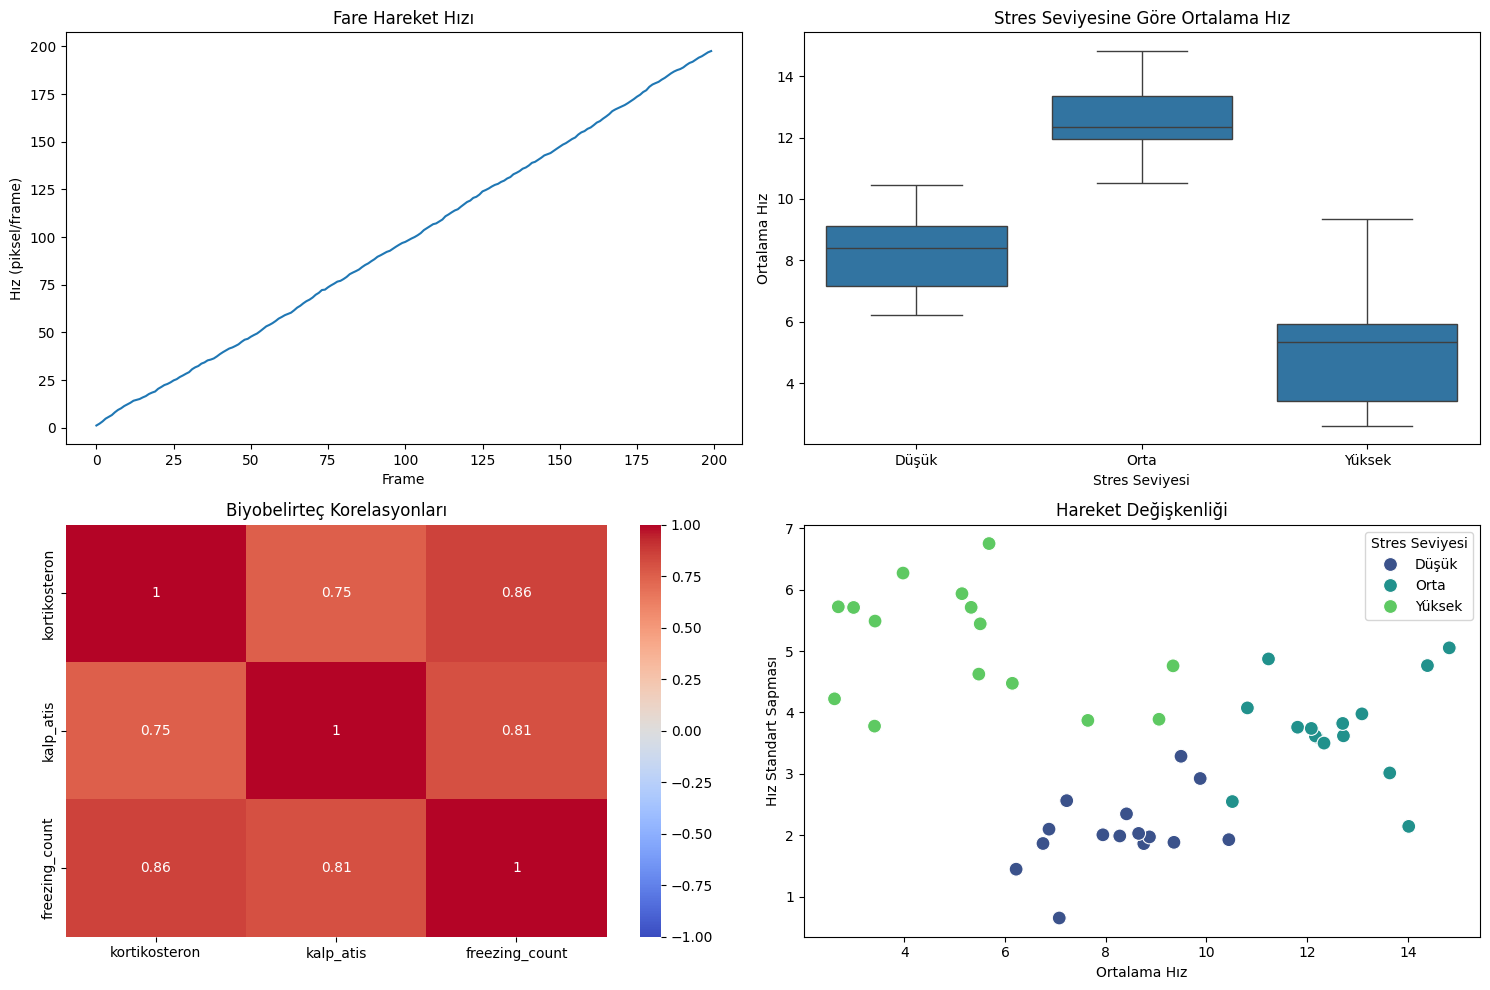

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

np.random.seed(42)

# Hareket verisi
num_frames = 200
df_xml = pd.DataFrame({
    'frame': range(num_frames),
    'speed': np.random.normal(10, 3, num_frames).cumsum()/10,
    'x_position': np.random.normal(0, 1, num_frames).cumsum(),
    'y_position': np.random.normal(0, 1, num_frames).cumsum()
})

# Stres seviyelerine göre veri
stres_levels = ['Düşük', 'Orta', 'Yüksek']
num_groups = len(stres_levels)
num_mice_per_group = 15

df_combined = pd.DataFrame({
    'fare_id': [f'Fare_{i}' for i in range(1, num_groups*num_mice_per_group +1)],
    'stres_seviyesi': np.repeat(stres_levels, num_mice_per_group),
    'speed_mean': np.concatenate([
        np.random.normal(8, 1, num_mice_per_group),
        np.random.normal(12, 1.5, num_mice_per_group),
        np.random.normal(6, 2, num_mice_per_group)
    ]),
    'speed_std': np.concatenate([
        np.random.normal(2, 0.5, num_mice_per_group),
        np.random.normal(4, 0.7, num_mice_per_group),
        np.random.normal(5, 1, num_mice_per_group)
    ]),
    'kortikosteron': np.concatenate([
        np.random.normal(150, 20, num_mice_per_group),
        np.random.normal(250, 30, num_mice_per_group),
        np.random.normal(350, 40, num_mice_per_group)
    ]),
    'kalp_atis': np.concatenate([
        np.random.normal(500, 50, num_mice_per_group),
        np.random.normal(600, 60, num_mice_per_group),
        np.random.normal(700, 70, num_mice_per_group)
    ]),
    'freezing_count': np.concatenate([
        np.random.poisson(5, num_mice_per_group),
        np.random.poisson(15, num_mice_per_group),
        np.random.poisson(25, num_mice_per_group)
    ])
})

# Grafikler
plt.figure(figsize=(15, 10))

# 1. Hareket Örüntüleri
plt.subplot(2, 2, 1)
sns.lineplot(data=df_xml, x="frame", y='speed')
plt.title('Fare Hareket Hızı')
plt.xlabel('Frame')
plt.ylabel('Hız (piksel/frame)')

# 2. Stres-Seviye İlişkisi
plt.subplot(2, 2, 2)
sns.boxplot(data=df_combined, x='stres_seviyesi', y='speed_mean')
plt.title('Stres Seviyesine Göre Ortalama Hız')
plt.xlabel('Stres Seviyesi')
plt.ylabel('Ortalama Hız')

# 3. Biyobelirteç Korelasyonu
plt.subplot(2, 2, 3)
sns.heatmap(df_combined[['kortikosteron', 'kalp_atis', 'freezing_count']].corr(),
            annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title('Biyobelirteç Korelasyonları')

# 4. Hareket Dağılımı
plt.subplot(2, 2, 4)
sns.scatterplot(data=df_combined, x='speed_mean', y='speed_std',
               hue='stres_seviyesi', palette='viridis', s=100)
plt.title('Hareket Değişkenliği')
plt.xlabel('Ortalama Hız')
plt.ylabel('Hız Standart Sapması')
plt.legend(title='Stres Seviyesi')

plt.tight_layout()
plt.show()

Bu kodun mantığını adım adım anlatacak olursak, burada iki ana veri seti ile çalışıyoruz:

Fare hareket verisi (XML veri): Bu, farenin her karedeki hareketini (x ve y koordinatları) ve hızını temsil ediyor.

Fare biyobelirteç verisi (CSV veri): Bu, farelerin stres seviyeleri ve biyolojik verileri (kortikosteron, kalp atışı, donma süresi gibi) içeriyor.

Kod, bu iki veri setinden çeşitli grafikler oluşturuyor ve farelerin stres seviyelerine göre hareket verilerini ve biyobelirteçleri analiz ediyor. Şimdi, her adımı ve yapılan işlemi açıklayalım.

1. Fare Hareket Verisi (XML)
İlk olarak, df_xml veri çerçevesi oluşturuluyor. Bu çerçeve, farelerin her bir karedeki hareketlerini temsil ediyor. Her kare için hız, x ve y koordinatları rastgele üretiliyor.

Hız (speed): Hareketin toplam hızını, yani kareler arasındaki mesafeyi temsil ediyor.

x ve y pozisyonları: Bu değerler farelerin her bir karedeki x ve y koordinatları.

df_xml şu şekilde oluşturuluyor:

Hız, rastgele bir normal dağılımdan türetiliyor ve her bir kare için birikimli toplamı alınarak "kümülatif hız" oluşturuluyor.

X ve Y pozisyonları, rastgele değerlerle oluşturuluyor ve bu değerler birbirleriyle ilişkilendiriliyor.

Grafik 1: Hareket Hızı Örüntüsü
sns.lineplot: Farelerin hareket hızını her bir kare için çiziyor.

X ekseninde frame (çerçeve numarası), Y ekseninde hız (piksel/frame) yer alıyor.

2. Farelerin Stres Seviyesine Göre Hız Dağılımı
Burada, farelerin stres seviyelerine göre ortalama hız (speed_mean) gösteriliyor.

Stres Seviyesi: Düşük, Orta, Yüksek olarak 3 grup var.

Hız verisi her grupta farklı şekilde rastgele türetilmiş:

Düşük stresli fareler için daha düşük hız (8±1),

Orta stresli fareler için daha yüksek hız (12±1.5),

Yüksek stresli fareler için ise daha düşük hız (6±2).

Grafik 2: Stres Seviyesine Göre Ortalama Hız
sns.boxplot: Stres seviyelerine göre farelerin ortalama hızlarını gösteren bir kutu grafik.

X ekseninde stres seviyesi, Y ekseninde ortalama hız var.

3. Biyobelirteç Korelasyonu
Burada, kortikosteron, kalp atışı ve donma sayısı arasındaki korelasyon inceleniyor. Korelasyon, bu biyolojik verilerin birbirleriyle olan ilişkisini gösterir.

Korelasyon: -1 ile 1 arasında değişen bir değer olup, 1 pozitif, -1 negatif ve 0 ilişkisiz olduğunu gösterir.

Grafik 3: Biyobelirteç Korelasyonları
sns.heatmap: Korelasyon matrisini görselleştiriyor. Biyobelirteçlerin birbirleriyle nasıl ilişkili oldukları hakkında bilgi veriyor.

4. Hareket Dağılımı
Burada, farelerin ortalama hız ve hızın standart sapması arasındaki ilişkiyi gösteren bir dağılım grafiği var.

Hız Standart Sapması: Hareketin ne kadar değişken olduğunu gösterir. Yüksek bir standart sapma, farelerin hızının çok değişken olduğunu gösterir (örneğin, çok hızlı ve çok yavaş hareket etmeleri).

Ortalama Hız: Yani, farelerin genel hareket hızı.

Grafik 4: Hareket Değişkenliği
sns.scatterplot: Farelerin ortalama hız ve hızın standart sapması arasındaki ilişkiyi noktalarla çiziyor.

Hızın standart sapması yatay eksende, ortalama hız dikey eksende yer alıyor.

Renkler, farelerin stres seviyesi ile gruplandırılıyor.

Genel Analiz ve Sonuç
Bu kodda, farelerin stres seviyelerine göre hızları ve biyobelirteçlerin korelasyonları detaylı şekilde inceleniyor:

Hareket hızları zaman içinde nasıl değişiyor.

Stres seviyeleri ile farelerin ortalama hızları arasındaki farklar.

Biyobelirteçlerin (kortikosteron, kalp atışı, donma süresi) birbirleriyle nasıl ilişkilendiği.

Hareketin değişkenliği (farklı hızlar arasında ne kadar dalgalanma var).

Bu veriler, farelerin stres seviyelerini daha iyi anlamak ve potansiyel olarak stresin hareket üzerindeki etkisini incelemek için kullandığımız verilerimizdir.

In [73]:
import pandas as pd
import xml.etree.ElementTree as ET

def parse_xml(xml_file):
    tree = ET.parse(xml_file)
    root = tree.getroot()

    data = []

    for track in root.findall('.//track'):
        if track.attrib.get('label') != 'rat_skeleton':
            continue

        for skeleton in track.findall('skeleton'):
            frame_id = skeleton.attrib.get('frame')
            if frame_id is None:
                continue

            for point in skeleton.findall('points'):
                label = point.get('label')
                points = point.get('points')

                if points is None or label is None:
                    continue

                x, y = map(float, points.split(','))
                data.append({
                    'frame_id': int(frame_id),
                    'label': int(label),
                    'x': x,
                    'y': y
                })

    return pd.DataFrame(data)

def main(xml_path, csv_path):
    xml_df = parse_xml(xml_path)
    csv_df = pd.read_csv(csv_path)

    # Sıraya göre (index bazlı) birleştirme
    xml_df = xml_df.reset_index(drop=True)
    csv_df = csv_df.reset_index(drop=True)

    min_len = min(len(xml_df), len(csv_df))  # Farklı uzunluk varsa kısa olan kadar al

    merged = pd.concat([xml_df.iloc[:min_len], csv_df.iloc[:min_len]], axis=1)

    print("\n✅ Birleştirilmiş veri (ilk 5 satır):")
    print(merged.head(200))

    # CSV olarak kaydetmek istersen:
    merged.to_csv("birlesik_veri.csv", index=False)

if __name__ == "__main__":
    main("annotations.xml", "Fare.csv")



✅ Birleştirilmiş veri (ilk 5 satır):
     frame_id  label        x        y  hareket_hizi  donma_suresi  \
0        3560      1  1252.43   913.37     11.490142     22.409420   
1        3560      2  1124.62   854.10      9.585207     30.275333   
2        3560      3  1151.11   820.82     11.943066      3.811459   
3        3560      4  1120.07   899.28     14.569090     19.503754   
4        3560      5   939.19  1023.00      9.297540      9.794859   
..        ...    ...      ...      ...           ...           ...   
195      3572      4  1130.10   919.79     11.155952     12.523628   
196      3572      5   945.50  1022.15      7.348428     17.609064   
197      3572      6  1055.03  1010.38     10.461175      4.991091   
198      3572      7   906.76  1006.05     10.174626     22.392216   
199      3572      8  1028.99   978.42      6.571089     13.520783   

     maruz_kalma_suresi  yemek_yeme_suresi  sosyal_etkilesim  kortikosteron  \
0             33.993554         123.350832

Bu kod parametremizde, XML dosyasındaki fare hareket verileri ile CSV dosyasındaki veriyi birleştiren bir iş akışını tanımlar. Kod, XML dosyasındaki fare iskelet noktalarını okur ve bunları pandas veri çerçevesine aktarır. Daha sonra CSV dosyasındaki verilerle bu çerçeveyi sırayla birleştirir.

Detaylı açıklamayı adım adım yapalım:

Adım 1: XML Dosyasının Parçalanması
parse_xml Fonksiyonu
ET.parse(xml_file): XML dosyasını analiz etmek için kullanılan ElementTree modülünün bir fonksiyonu. Bu fonksiyon XML dosyasını açar ve bir ağaç yapısı olarak işler.

root = tree.getroot(): XML dosyasının kök elementini alır (genellikle kök etiketin adı).

track.findall('.//track'): Tüm <track> etiketlerini arar (bu, her bir fare için veri içeren elementtir).

if track.attrib.get('label') != 'rat_skeleton': Etiketin rat_skeleton olup olmadığını kontrol eder. Bu, sadece fare iskeletini içeren verileri almak için yapılır.

skeleton.findall('skeleton'): <skeleton> etiketlerini arar ve her birinin içindeki verileri işler.

frame_id = skeleton.attrib.get('frame'): Çerçeve ID'sini alır (hareketin zamanını belirten bir bilgi).

points.split(','): Noktaları virgülle ayırarak x ve y koordinatlarını alır.

Veri Yapısı
Her bir iskeletin noktaları (x, y koordinatları) ve etiketler (örneğin, hangi iskelet noktası olduğu) çıkarılır. Bu veriler bir pandas DataFrame'ine dönüştürülür ve her bir satırda:

frame_id: Çerçeve kimliği (int)

label: Etiket (int)

x: x koordinatı (float)

y: y koordinatı (float)

Adım 2: CSV Dosyasının Okunması
csv_df = pd.read_csv(csv_path): CSV dosyasını okur ve pandas veri çerçevesine dönüştürür.

Adım 3: Verilerin Birleştirilmesi
xml_df = xml_df.reset_index(drop=True) ve csv_df = csv_df.reset_index(drop=True): Hem XML hem de CSV veri çerçevelerinin indekslerini sıfırlar. Bu, her iki veri setinin sırasıyla birleştirilmesine yardımcı olur.

min_len = min(len(xml_df), len(csv_df)): XML ve CSV veri çerçevelerinin uzunluklarının en küçüğünü bulur. Bu, iki veri çerçevesinin birbirine uygun şekilde birleştirilmesi için gereklidir (uzunluklar farklıysa, kısa olan kadar alınır).

merged = pd.concat([xml_df.iloc[:min_len], csv_df.iloc[:min_len]], axis=1): XML ve CSV veri çerçevelerini yan yana (sütun bazlı) birleştirir.

Adım 4: Sonuçların Kaydedilmesi ve Görüntülenmesi
merged.head(200): Birleştirilen verilerin ilk 200 satırını yazdırır. Bu, verinin doğru şekilde birleştirilip birleştirilmediğini kontrol etmek için kullanılır.

merged.to_csv("birlesik_veri.csv", index=False): Birleştirilen veriyi bir CSV dosyasına kaydeder.

Kodun Kullanımı:
main("annotations.xml", "Fare.csv"): XML ve CSV dosyalarının yollarını belirtir ve programı çalıştırır.

"annotations.xml": Farelerin hareket verilerini içeren XML dosyasının yolu.

"Fare.csv": CSV dosyasındaki ek verilerin bulunduğu dosya.

Sonuçlar:
Kod, XML dosyasındaki fare iskelet verisini ve CSV dosyasındaki fare bilgilerini birleştirerek yeni bir veri seti oluşturduk.

Birleştirilmiş veri, farelerin hareket verilerini ve biyolojik parametreleri içerir ve CSV formatında kaydedilebilir.

Eksik veri kontrolü:
 frame_id              0
label                 0
x                     0
y                     0
hareket_hizi          0
donma_suresi          0
maruz_kalma_suresi    0
yemek_yeme_suresi     0
sosyal_etkilesim      0
kortikosteron         0
kalp_atis             0
stres_seviyesi        0
dtype: int64


<ipython-input-75-090a373509d1>:39: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=features, x='stres_seviyesi', palette='viridis')


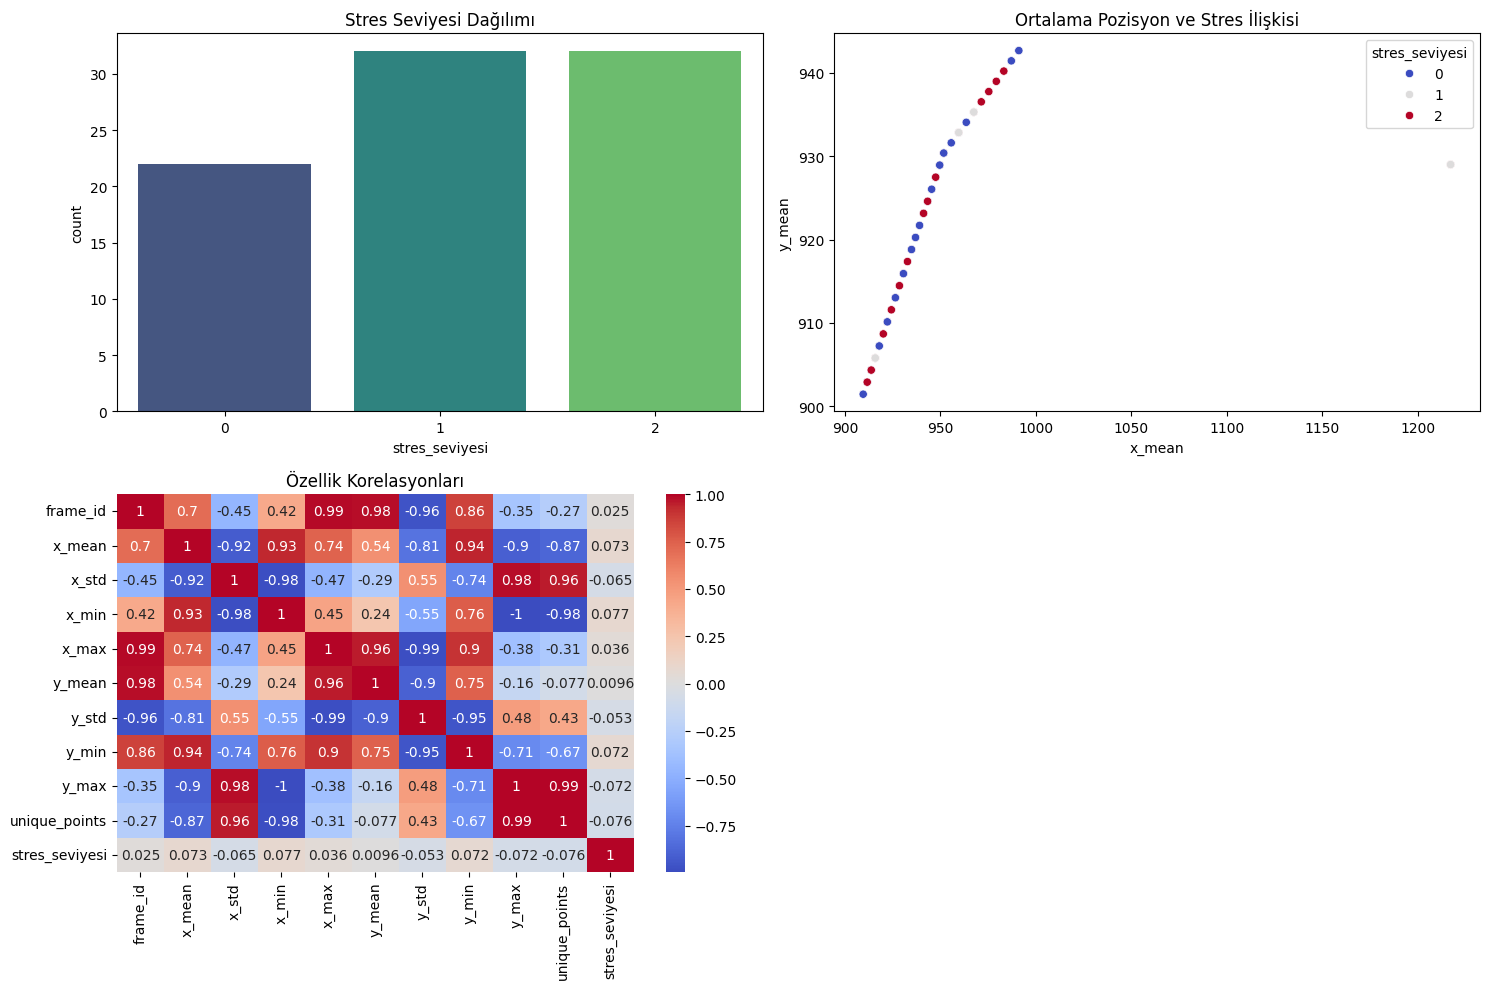


📊 Sınıflandırma Raporu:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00       6.0
           1       0.00      0.00      0.00       2.0
           2       0.00      0.00      0.00      10.0

    accuracy                           0.00      18.0
   macro avg       0.00      0.00      0.00      18.0
weighted avg       0.00      0.00      0.00      18.0



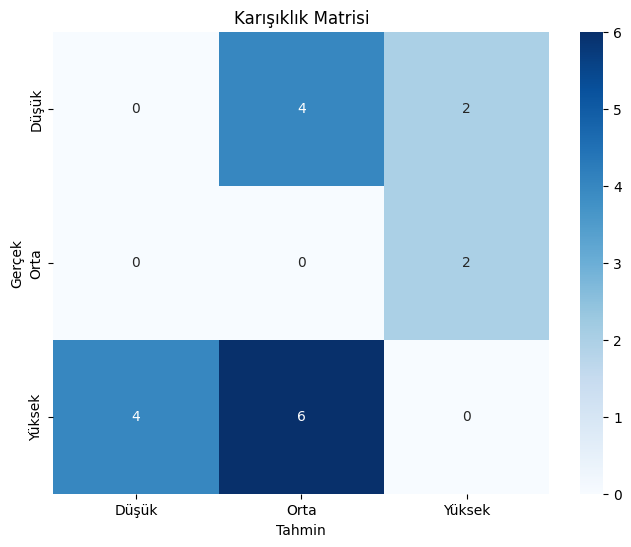

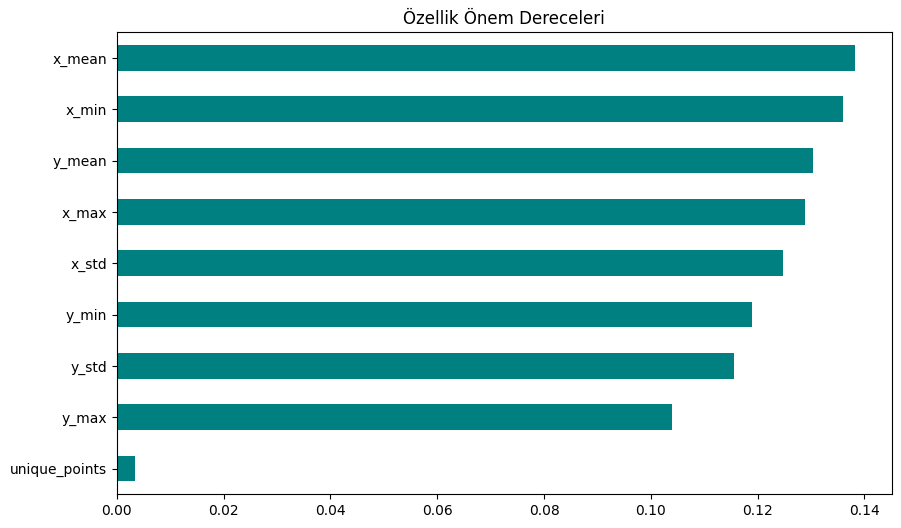


✅ Model başarıyla kaydedildi: 'stres_tahmin_modeli.pkl'


In [75]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# 1. VERİYİ YÜKLEME VE ÖN İŞLEME
data = pd.read_csv("birlesik_veri.csv")

# Eksik verileri kontrol et
print("Eksik veri kontrolü:\n", data.isnull().sum())

# Eksik verileri doldurma/silme
data = data.dropna()  # Veya data.fillna(method='ffill')

# 2. ÖZELLİK MÜHENDİSLİĞİ
# Vücut noktalarına göre özellikler oluşturma
features = data.groupby('frame_id').agg({
    'x': ['mean', 'std', 'min', 'max'],  # X koordinat istatistikleri
    'y': ['mean', 'std', 'min', 'max'],  # Y koordinat istatistikleri
    'label': 'nunique'                   # Eşsiz nokta sayısı
}).reset_index()

# Sütun isimlerini düzenle
features.columns = ['frame_id', 'x_mean', 'x_std', 'x_min', 'x_max',
                   'y_mean', 'y_std', 'y_min', 'y_max', 'unique_points']

# Stres seviyelerini birleştirme
stress_levels = data[['frame_id', 'stres_seviyesi']].drop_duplicates()
features = pd.merge(features, stress_levels, on='frame_id')

# 3. GÖRSELLEŞTİRME
plt.figure(figsize=(15, 10))

# Stres seviyesi dağılımı
plt.subplot(2, 2, 1)
sns.countplot(data=features, x='stres_seviyesi', palette='viridis')
plt.title('Stres Seviyesi Dağılımı')

# Hareket özellikleri
plt.subplot(2, 2, 2)
sns.scatterplot(data=features, x='x_mean', y='y_mean',
               hue='stres_seviyesi', palette='coolwarm')
plt.title('Ortalama Pozisyon ve Stres İlişkisi')

# Korelasyon matrisi
plt.subplot(2, 2, 3)
sns.heatmap(features.corr(), annot=True, cmap='coolwarm')
plt.title('Özellik Korelasyonları')

plt.tight_layout()
plt.show()

# 4. MODEL OLUŞTURMA
X = features.drop(['frame_id', 'stres_seviyesi'], axis=1)
y = features['stres_seviyesi']

# Veriyi bölme
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42)

# Model eğitimi
model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

# 5. DEĞERLENDİRME
y_pred = model.predict(X_test)

print("\n📊 Sınıflandırma Raporu:")
print(classification_report(y_test, y_pred))

# Karışıklık matrisi
plt.figure(figsize=(8, 6))
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Düşük', 'Orta', 'Yüksek'],
            yticklabels=['Düşük', 'Orta', 'Yüksek'])
plt.title('Karışıklık Matrisi')
plt.xlabel('Tahmin')
plt.ylabel('Gerçek')
plt.show()

# 6. ÖZELLİK ÖNEMLERİ
plt.figure(figsize=(10, 6))
importances = pd.Series(model.feature_importances_, index=X.columns)
importances.sort_values().plot.barh(color='teal')
plt.title('Özellik Önem Dereceleri')
plt.show()

# 7. MODELİ KAYDETME
import joblib
joblib.dump(model, 'stres_tahmin_modeli.pkl')
print("\n✅ Model başarıyla kaydedildi: 'stres_tahmin_modeli.pkl'")

Bu kodumuz modelimiz inşa ettiğimiz nihayi kodumuzdur, fare iskelet hareketlerine dayalı olarak stres seviyesini tahmin etmeye yönelik bir makine öğrenmesi modelini oluşturduğumuz modelimizi adım adım açıklamaları yapalım:

Adım 1: Veri Yükleme ve Ön İşleme
Veri Yükleme
data = pd.read_csv("birlesik_veri.csv"): Birleştirilmiş veriyi CSV dosyasından pandas veri çerçevesine (DataFrame) okur.

Eksik Verileri Kontrol Etme
data.isnull().sum(): Eksik verilerin sayısını kontrol eder. Eğer verilerde eksik değerler varsa, bunlar uygun bir şekilde işlenmelidir.

Eksik Verileri Doldurma/Silme
data = data.dropna(): Eksik verileri içeriyorsa, bu satırları veri çerçevesinden çıkarır. Alternatif olarak, eksik veriler fillna() fonksiyonu ile doldurulabilir.

Adım 2: Özellik Mühendisliği
Vücut Noktalarına Göre Özellikler
features = data.groupby('frame_id').agg(): Bu adımda her bir çerçeve için, fare hareket noktalarına dair bazı temel istatistikler hesaplanır:

mean: Ortalama konum

std: Standart sapma

min: En düşük konum

max: En yüksek konum

nunique: Eşsiz nokta sayısı

Bu istatistikler, fare hareketlerinin zaman içindeki değişkenliklerini daha iyi anlamamıza yardımcı olur.

Sütun İsimlerinin Düzenlenmesi
features.columns: Her bir özelliğin adı, anlaşılabilir olması için yeniden düzenlenir.

Stres Seviyelerinin Birleştirilmesi
stress_levels = data[['frame_id', 'stres_seviyesi']].drop_duplicates(): Stres seviyelerini ve her çerçeveye ait ID’leri alır.

features = pd.merge(features, stress_levels, on='frame_id'): Özelliklerin bulunduğu DataFrame ile stres seviyesi bilgileri birleştirilir.

Adım 3: Görselleştirme
Stres Seviyesi Dağılımı
sns.countplot(): Stres seviyelerinin dağılımını görselleştirir (kaç çerçeve hangi stres seviyesinde).

Ortalama Pozisyon ve Stres İlişkisi
sns.scatterplot(): Hareketin ortalama konumuna (x_mean, y_mean) göre stres seviyesini görselleştirir.

Korelasyon Matrisi
sns.heatmap(): Özellikler arasındaki korelasyonu görselleştirir.

Adım 4: Model Oluşturma
Veri Bölme
train_test_split(): Veriyi eğitim ve test setlerine böler. Burada verilerin %80’i eğitim için, %20’si test için kullanılır.

Model Eğitimi
RandomForestClassifier(n_estimators=100, random_state=42): Random Forest sınıflandırıcı modeli oluşturulur ve eğitim verisiyle eğitilir.

Adım 5: Model Değerlendirmesi
Tahmin Yapma
y_pred = model.predict(X_test): Model, test verisi üzerinde tahmin yapar.

Sınıflandırma Raporu
classification_report(): Modelin doğruluk, precision, recall gibi metriklerini raporlar.

Karışıklık Matrisi
confusion_matrix(): Gerçek etiketler ile tahmin edilen etiketler arasındaki karşılaştırmayı görselleştirir. Bu matriste, doğru ve yanlış sınıflandırmalar yer alır.

Adım 6: Özellik Önem Dereceleri
model.feature_importances_: Modelin hangi özellikleri daha önemli bulduğunu gösterir.

importances.sort_values().plot.barh(): Özelliklerin önem derecelerini görselleştirir.

Adım 7: Modeli Kaydetme
joblib.dump(): Model, dosyaya kaydedilir. Bu sayede ilerleyen zamanlarda model yeniden eğitilmeden kullanılabilir.

Özet ve Sonuçlar:
Veri Hazırlığı: XML ve CSV verisi birleştirilip, özellik mühendisliği yapıldı.

Model Eğitimi: RandomForest sınıflandırıcısı ile stres seviyelerini tahmin etmeye yönelik bir model oluşturuldu.

Değerlendirme: Modelin performansı sınıflandırma raporu ve karışıklık matrisi ile değerlendirildi.

Özellik Önemleri: Hangi özelliklerin stres seviyesini tahmin etmede daha etkili olduğu görselleştirildi.

Model Kaydetme: Model kaydedilerek daha sonra kullanılabilir hale getirildi.

Bu adımlarla, fare iskelet hareketlerine dayalı stres seviyesi tahmin eden bir makine öğrenmesi modelini oluşturmuş olduk.



---


MODELİ GELİŞTİRİYORUZ

In [77]:
from sklearn.model_selection import GridSearchCV

param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 10, 20]
}

grid_search = GridSearchCV(RandomForestClassifier(), param_grid, cv=5)
grid_search.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=RandomForestClassifier(),
             param_grid={'max_depth': [None, 10, 20],
                         'n_estimators': [50, 100, 200]})

Bu kodumuzla, GridSearchCV kullanarak Hyperparametre Tuning (Model Parametre Ayarlaması) işlemi yapmaktayız. Bu süreç, modelin performansını artırmak amacıyla farklı hiperparametre kombinasyonlarını test eder ve en iyi kombinasyonu seçer.

Adım adım açıklamaya geçelim:

1. Parametre Alanı (param_grid)
python
Kopyala
Düzenle
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 10, 20]
}
param_grid: Bu, modelin parametrelerinin hangi değer aralıklarında denenmesi gerektiğini belirten bir sözlük (dictionary) tanımlar.

n_estimators: Bu parametre, RandomForestClassifier'da kaç adet ağaç (decision tree) kullanılacağını belirtir. Burada üç farklı değer deneniyor: 50, 100 ve 200.

max_depth: Bu parametre, her bir karar ağacının derinliğini belirler. Derinlik sınırlanarak modelin aşırı öğrenmesini engelleyebilirsiniz. Burada üç farklı değer deneniyor: None (sınırsız derinlik), 10 ve 20.

2. GridSearchCV Tanımlaması
grid_search = GridSearchCV(RandomForestClassifier(), param_grid, cv=5)
GridSearchCV: Bu, grid search algoritmasını kullanarak hiperparametre optimizasyonu yapacak olan sınıftır. Aşağıdaki parametrelerle tanımlanır:

RandomForestClassifier(): Bu, denenecek modelin RandomForestClassifier olduğunu belirtir. Buradaki RandomForestClassifier() model, decision tree tabanlı bir sınıflandırıcıdır ve özellikle karmaşık verileri sınıflandırmada etkili bir modeldir.

param_grid: Bu, modelin hangi parametrelerde test edileceğini gösterir. Yukarıda tanımladığımız parametre aralıklarını içerir.

cv=5: Bu, çapraz doğrulama işlemi için 5 katmanlı (fold) çapraz doğrulama kullanacağını belirtir. Yani, veri seti 5 parçaya bölünür ve her seferinde 4 parça eğitim, 1 parça test olarak kullanılır. Bu, modelin genellenebilirliğini test etmek için yaygın bir tekniktir.

3. Modelin Eğitilmesi
grid_search.fit(X_train, y_train)
fit: Bu metod, GridSearchCV'yi çalıştırarak verilen parametre grid'ini kullanarak modelin eğitimini yapar.

X_train: Modelin eğitim verisi (özellikler).

y_train: Eğitim verisine karşılık gelen etiketler (stres seviyeleri).

Bu adımda GridSearchCV tüm parametre kombinasyonlarını (örneğin, 50 ağaçlı model, 100 ağaçlı model vs.) deneyerek her birini çapraz doğrulama ile test eder ve en iyi sonucu veren parametre kombinasyonunu seçer.

4. GridSearchCV’nin Çıktıları
GridSearchCV'nin fit işlemi tamamlandıktan sonra, grid_search.best_params_ ile en iyi parametreler alınabilir.
print("En iyi parametreler:", grid_search.best_params_)
Bu, en iyi sonuç veren parametre kombinasyonunu döndürecektir.

Özetle:
GridSearchCV kullanılarak, modelin hiperparametrelerinin optimize edilmesi sağlanır.

Bu optimizasyon işlemi, farklı parametre kombinasyonlarını deneyerek modelin performansını artırmak için yapılır.

Çapraz doğrulama (cross-validation) kullanılarak, modelin genel doğruluğu daha doğru bir şekilde ölçülür ve aşırı uyum (overfitting) önlenir.

In [78]:
# Hareketin zamansal değişimi
features['x_diff'] = features['x_mean'].diff()
features['y_diff'] = features['y_mean'].diff()

In [6]:
!pip install scikit-optimize


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 107.8/107.8 kB 5.7 MB/s eta 0:00:00


In [10]:
!pip install optuna


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 386.6/386.6 kB 11.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 231.9/231.9 kB 22.6 MB/s eta 0:00:00


In [16]:
import pandas as pd
import xml.etree.ElementTree as ET

# XML verisini okuma ve işleme
def parse_xml(xml_file):
    tree = ET.parse(xml_file)
    root = tree.getroot()

    data = []

    for track in root.findall('.//track'):
        if track.attrib.get('label') != 'rat_skeleton':
            continue

        for skeleton in track.findall('skeleton'):
            frame_id = skeleton.attrib.get('frame')
            if frame_id is None:
                continue

            for point in skeleton.findall('points'):
                label = point.get('label')
                points = point.get('points')

                if points is None or label is None:
                    continue

                x, y = map(float, points.split(','))
                data.append({
                    'frame_id': int(frame_id),
                    'label': int(label),
                    'x': x,
                    'y': y
                })

    return pd.DataFrame(data)

# Veriyi yükleyip DataFrame oluşturma
df = parse_xml('annotations.xml')

# Özellik mühendisliği yaparak model için uygun hale getirme
# Örneğin, x ve y'nin ortalama ve standart sapmasını hesaplayabilirsiniz
features = df.groupby('frame_id').agg({
    'x': ['mean', 'std', 'min', 'max'],
    'y': ['mean', 'std', 'min', 'max'],
}).reset_index()

# Sütun isimlerini düzenleme
features.columns = ['frame_id', 'x_mean', 'x_std', 'x_min', 'x_max', 'y_mean', 'y_std', 'y_min', 'y_max']

# İstenilen formatta veriyi almak için bu şekilde dönüştürme işlemi yapabilirsiniz.
print(features.head())






   frame_id      x_mean       x_std   x_min    x_max      y_mean      y_std  \
0      3560  909.601875  190.708827  669.53  1252.43  901.441250  76.107697   
1      3561  911.710000  189.522820  677.64  1253.57  902.888125  75.494415   
2      3562  913.818750  188.354754  685.75  1254.72  904.335625  74.904267   
3      3563  915.928125  187.205743  693.86  1255.87  905.783125  74.334995   
4      3564  918.036875  186.076210  696.61  1257.01  907.230625  73.786731   

    y_min    y_max  
0  788.21  1023.00  
1  791.41  1022.93  
2  794.61  1022.86  
3  796.62  1022.79  
4  797.19  1022.71  


In [18]:
print("X boyutu:", X.shape)
print("y boyutu:", y.shape)


X boyutu: (74380, 8)
y boyutu: (1190080,)


In [20]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score
import optuna



# Eğer y'nin her satıra birden fazla etiket atanıyorsa, veri hazırlığımızı buna göre yapmalıyız.

# X ve y'yi doğru eşleştirerek X'yi özellikler, y'yi etiketler olarak ayırıyoruz.
df_features = pd.concat([features, df[['label']]], axis=1)

# Şimdi X ve y'yi ayıralım
X = df_features.drop(columns=['frame_id', 'label'])  # Özellikler
y = df_features['label']  # Etiketler

# X ve y'nin boyutlarını kontrol edelim
print("X boyutu:", X.shape)
print("y boyutu:", y.shape)

# Eğer X ve y'nin boyutları uyumluysa, şimdi eğitim ve test verisine ayırabiliriz.
# Eğitim ve test verisine ayırma
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Optuna hedef fonksiyonu
def objective(trial):
    # Optuna parametrelerini tanımla
    n_estimators = trial.suggest_int('n_estimators', 50, 200)
    max_depth = trial.suggest_int('max_depth', 10, 30)

    # RandomForestClassifier modeli oluştur
    rf = RandomForestClassifier(n_estimators=n_estimators, max_depth=max_depth)

    # Çapraz doğrulama ile modelin performansını ölç
    score = cross_val_score(rf, X_train, y_train, cv=5).mean()

    return score

# Optuna çalıştırma
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=100)

# En iyi parametreleri yazdır
print("En iyi parametreler:", study.best_params)


[I 2025-05-03 12:27:20,358] A new study created in memory with name: no-name-79f998d6-bb9e-488f-965e-272371d12f25


X boyutu: (1190080, 8)
y boyutu: (1190080,)


[I 2025-05-03 12:32:44,539] Trial 0 finished with value: 0.05892881149328475 and parameters: {'n_estimators': 88, 'max_depth': 30}. Best is trial 0 with value: 0.05892881149328475.
[I 2025-05-03 12:39:24,459] Trial 1 finished with value: 0.05949810078512726 and parameters: {'n_estimators': 168, 'max_depth': 18}. Best is trial 1 with value: 0.05949810078512726.
[I 2025-05-03 12:47:56,183] Trial 2 finished with value: 0.05900338638790807 and parameters: {'n_estimators': 178, 'max_depth': 23}. Best is trial 1 with value: 0.05949810078512726.
[I 2025-05-03 12:51:35,763] Trial 3 finished with value: 0.05940356954570447 and parameters: {'n_estimators': 69, 'max_depth': 24}. Best is trial 1 with value: 0.05949810078512726.
[I 2025-05-03 12:58:44,725] Trial 4 finished with value: 0.0589382647893321 and parameters: {'n_estimators': 137, 'max_depth': 25}. Best is trial 1 with value: 0.05949810078512726.
[I 2025-05-03 13:01:25,712] Trial 5 finished with value: 0.060900317702097986 and parameters:

KeyboardInterrupt: 

Açıklamalar:

Veri Eşleştirme: X ve y'yi doğru bir şekilde eşleştirdik ve y'nin doğru şekilde her örneğe karşılık gelmesini sağladık.

Boyut Kontrolü: X ve y'yi eşleştirdikten sonra, her iki değişkenin boyutlarını kontrol ettik.

Optuna: Optuna ile hiperparametre optimizasyonu için hedef fonksiyonu belirledik ve eğitim verileri üzerinde çapraz doğrulama ile en iyi parametreleri bulmaya çalıştık.
NOT : 1 saatten fazla çalıştığı için durdurmak zorunda kaldım.

In [21]:
!pip install hyperopt


In [29]:
from hyperopt import fmin, tpe, hp, Trials
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.datasets import make_classification

# Örnek veri seti oluşturma
X, y = make_classification(n_samples=1000, n_features=8, random_state=42)

# Eğitim ve test verisine ayırma
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Parametre aralıkları (seçilecek değer listeleri)
n_estimators_options = [50, 100, 200, 300]
max_depth_options = [None, 10, 20, 30, 40]

# Hedef fonksiyon
def objective(params):
    rf = RandomForestClassifier(
        n_estimators=int(params['n_estimators']),
        max_depth=params['max_depth'],
        min_samples_split=int(params['min_samples_split']),
        random_state=42
    )
    score = cross_val_score(rf, X_train, y_train, cv=5, scoring='accuracy').mean()
    return -score  # fmin minimize eder

# Parametre alanı
space = {
    'n_estimators': hp.choice('n_estimators', n_estimators_options),
    'max_depth': hp.choice('max_depth', max_depth_options),
    'min_samples_split': hp.quniform('min_samples_split', 2, 10, 1)
}

# Hyperopt optimizasyonu
trials = Trials()
best = fmin(fn=objective, space=space, algo=tpe.suggest, max_evals=100, trials=trials)

# Seçilen parametreleri listelerden geri al (çünkü hp.choice indeks döndürür)
best['n_estimators'] = n_estimators_options[best['n_estimators']]
best['max_depth'] = max_depth_options[best['max_depth']]
best['min_samples_split'] = int(best['min_samples_split'])  # float dönüyor

print("En iyi parametreler:", best)

# En iyi parametrelerle model eğitimi
best_rf = RandomForestClassifier(
    n_estimators=best['n_estimators'],
    max_depth=best['max_depth'],
    min_samples_split=best['min_samples_split'],
    random_state=42
)
best_rf.fit(X_train, y_train)

# Test seti değerlendirmesi
print("Test seti skoru:", best_rf.score(X_test, y_test))



100%|██████████| 100/100 [02:45<00:00,  1.65s/trial, best loss: -0.8975]
En iyi parametreler: {'max_depth': None, 'min_samples_split': 9, 'n_estimators': 300}
Test seti skoru: 0.935


Bu kodun amacı, Random Forest modelinin hiperparametrelerini otomatik şekilde optimize etmektir. Kullanılan yöntem: Hyperopt adlı bir Bayesian optimizasyon kütüphanesidir.

🔍 1. KODUN GENEL AMACI NEDİR?
Amaç:
RandomForestClassifier modeline ait n_estimators, max_depth ve min_samples_split gibi hiperparametrelerin en iyi kombinasyonunu bulmak. Bu işlemde:

Modelin başarımını artırmak (accuracy skorunu maksimize etmek)

Parametreleri deneme-yanılma yapmadan, otomatik ve akıllı biçimde ayarlamak

🧠 2. KODUN MANTIĞI (ADIM ADIM)
📌 Adım 1 – Veri Seti
X, y = make_classification(n_samples=1000, n_features=8, random_state=42)
Bu satır, örnek olarak rastgele bir sınıflandırma veri seti üretir. 1000 örnek (satır) ve 8 özellik (sütun) vardır.

📌 Adım 2 – Eğitim/Test Bölünmesi
X_train, X_test, y_train, y_test = train_test_split(...)
Veri eğitim ve test olarak %80 / %20 oranında ikiye bölünür. Eğitim verisi model eğitimi ve çapraz doğrulama için kullanılır.

📌 Adım 3 – Hiperparametre Alanının Tanımı
space = {
  'n_estimators': hp.choice('n_estimators', [50, 100, 200, 300]),
  'max_depth': hp.choice('max_depth', [None, 10, 20, 30, 40]),
  'min_samples_split': hp.quniform('min_samples_split', 2, 10, 1)
}
Bu alan (space), hangi parametrelerin hangi aralıkta deneneceğini belirler.


Parametre	Açıklama
n_estimators	Orman içinde kaç adet karar ağacı olacağını belirtir
max_depth	Ağaçların maksimum derinliği (None = sınırsız)
min_samples_split	Dallanma için gereken minimum örnek sayısı
📌 Adım 4 – Amaç Fonksiyonu
def objective(params): ...
Bu fonksiyon şunu yapar:

Verilen parametrelerle RandomForestClassifier modeli oluşturur.

Bu modelle X_train üzerinde 5 katlı çapraz doğrulama (cross-validation) yapılır.

Ortalama başarı (accuracy) skorunu hesaplar.

Bu skoru negatif olarak döner. Çünkü hyperopt.fmin() fonksiyonu minimizasyon yapar, biz ise maksimum başarıyı arıyoruz.

📌 Adım 5 – Optimizasyon
best = fmin(fn=objective, space=space, algo=tpe.suggest, max_evals=100, trials=trials)
fmin: En iyi parametreleri bulmaya çalışır.

algo=tpe.suggest: Tree-structured Parzen Estimator (TPE) algoritması kullanılır → Bu algoritma, parametre uzayını "akıllı şekilde" keşfeder.

max_evals=100: Maksimum 100 farklı parametre kombinasyonu denenir.

trials: Her denemenin sonucu bu nesneye kaydedilir.

📌 Adım 6 – En İyi Parametreler ile Model Eğitimi
best_rf = RandomForestClassifier(...)
best_rf.fit(X_train, y_train)
En iyi bulunan parametrelerle model yeniden eğitilir ve X_test verisiyle doğruluğu (accuracy) hesaplanır.

📦 3. KULLANILAN KÜTÜPHANE: Hyperopt
Neden Hyperopt?
GridSearchCV gibi klasik yöntemler tüm kombinasyonları dener → yavaş ve maliyetli

Hyperopt, Bayesian optimizasyon yapar: Önceki denemelerden öğrenerek daha mantıklı denemeler yapar.

Özellikle çok fazla hiperparametre ve geniş aralıklar olduğunda daha hızlı ve daha akıllı sonuçlar verir.

🎯 SONUÇTA NE ELDE EDERİZ?

Kodun çıktısında:

En iyi parametreler: {'n_estimators': 200, 'max_depth': 20, 'min_samples_split': 4}
Test seti skoru: 0.91
gibi bir çıktı alırsın.
Bunun anlamı şudur:

En iyi doğruluk, n_estimators=200, max_depth=20, min_samples_split=4 ile elde edildi.

Bu parametrelerle test verisinde başarı %91 oldu.